Import Statements:

In [1]:
import gym
from gym import spaces

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import time
import random
import copy

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical

Install for using box environments:

In [2]:
!pip install gym[box2d]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 15.1 MB/s 
     |████████████████████████████████| 1.8 MB 59.2 MB/s 
     |████████████████████████████████| 18.3 MB 122 kB/s 


In [3]:
!pip install gym[box1d]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
print(torch.cuda.is_available())
print(torch.version.cuda)
print(torch.cuda.get_device_name(0))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

True
11.3
Tesla T4


In [5]:
class DeterministicGridEnvironment(gym.Env):
  metadata = { 'render.modes': []}

  def __init__(self):
    self.observation_space = spaces.Discrete(16)
    self.action_space = spaces.Discrete(4)
    self.max_timesteps = 10
    self.rewards = np.array([[0,0,-6,0],[0,0,0,-6],[0,0,0,0],[5,0,5,10]])
    self.actions = {0:"Down",1:"Up",2:"Right",3:"Left"}
  
  def get_action(self, action):
    return self.actions[action]

  def reset(self):
    self.timestep = 0
    self.agent_pos = [0, 0]
    self.goal_pos = [3, 3]
    self.state = np.zeros((4, 4))
    self.state[tuple(self.agent_pos)] = 1
    self.state[tuple(self.goal_pos)] = 0.5
    self.rewards = np.array([[0,0,-6,0],[0,0,0,-6],[0,0,0,0],[5,0,5,10]])
    observation = self.state.flatten()
    return observation

  def step(self, action):
    done = False
    self.state = np.random.choice(self.observation_space.n)
    if action == 0:
      self.agent_pos[0] += 1
    if action == 1:
      self.agent_pos[0] -= 1
    if action == 2:
      self.agent_pos[1] += 1
    if action == 3:
      self.agent_pos[1] -= 1
    
    self.agent_pos = np.clip(self.agent_pos, 0, 3)
    self.state = np.zeros((4,4))
    if all(self.agent_pos == self.goal_pos):
      self.state[tuple(self.agent_pos)] = 1
      done = True
    else:
      self.state[tuple(self.agent_pos)] = 1
      self.state[tuple(self.goal_pos)] = 0.5
    observation = self.state.flatten()
    reward = self.rewards[tuple(self.agent_pos)]
    # remove the reward once and see if the final state is reached.
    self.rewards[tuple(self.agent_pos)] = 0
    self.timestep += 1
    if self.timestep >= self.max_timesteps:
      done = True
    info = {}

    return observation, reward, done, info

  def render(self):
    cmap=plt.cm.gnuplot
    plt.imshow(self.state,cmap=cmap)
    plt.imshow(self.rewards,cmap=plt.cm.brg,alpha=0.7)
    plt.show()

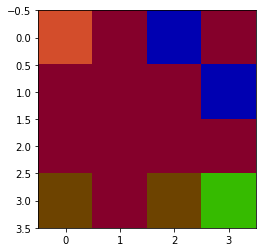

In [10]:
env = DeterministicGridEnvironment()
obs = env.reset()
env.render()

In [6]:
class AdvActorCrtici:
    def __init__(self, env, actor, critic, seed, numEpisodes, box, isMyEnv):
        self.env = env
        env.seed(seed)
        #If it is not a box env, get observation space from param n, else get from shape[0].
        if box == False:
            self.observation_space = self.env.observation_space.n
        else:
            self.observation_space = self.env.observation_space.shape[0]
        
        self.action_space = self.env.action_space.n
        self.cNet = critic(self.observation_space, seed).to(device)
        self.aNet = actor(self.observation_space, self.action_space, seed).to(device)
    
        self.seed = random.seed(seed)
        if isMyEnv: # Learing rate for grid environment is different from other two gym envc
          self.aoptim = optim.Adam(self.aNet.parameters(), lr = 0.1)
          self.cOptim = optim.Adam(self.cNet.parameters(), lr = 0.1)
        else:
          self.aoptim = optim.Adam(self.aNet.parameters(), lr = 0.001)
          self.cOptim = optim.Adam(self.cNet.parameters(), lr = 0.001)
        self.gamma = 0.995 
        self.numEpisodes = numEpisodes
        self.totalRewards = []
        self.evaltotalRewards = []
        self.avg = []
        self.evalavg = []
        
    def getAction(self, state):
        probs = self.aNet(state)
        dist = Categorical(probs=probs) # lib -> categorical
        action = dist.sample()
        #print(action)
        return action, dist
        
    def train(self):
        for i in range(self.numEpisodes):
            if i%100 == 0:
                print(i,'training...')
            state = self.env.reset()
            state = torch.tensor((state), dtype = torch.float, device = device)
            steps = 0
            totalReward = 0
            terminated = False
            while not terminated:
                action, dist= self.getAction(state)
                nxtStt, Stepreward, terminated, info = self.env.step(action.detach().data.cpu().numpy())
                nxtStt = torch.tensor((nxtStt), dtype = torch.float, device = device)
                advantage = Stepreward + (1-terminated)*self.gamma*self.cNet(nxtStt) - self.cNet(state)
                
                state = nxtStt
                
                loss_c = advantage.pow(2)[0]
                self.cOptim.zero_grad()
                loss_c.backward()
                self.cOptim.step()
                
                loss_a = -dist.log_prob(action)*advantage.detach()
                self.aoptim.zero_grad()
                loss_a.backward()
                self.aoptim.step()
                
                totalReward += Stepreward
                steps += 1
            
            if i>=500:
              self.evaltotalRewards.append(totalReward)     
              self.evalavg.append(totalReward/steps)
            else:
              self.totalRewards.append(totalReward)     
              self.avg.append(totalReward/steps)
        print('Finished training!!!!!!')

In [7]:
class Critic(nn.Module):
    def __init__(self, stateCnt, seed): #Get No of states and seed
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fullyConnected1 = nn.Linear(stateCnt, 32)
        self.fullyConnected2 = nn.Linear(32, 64)
        self.fullyConnected3 = nn.Linear(64, 1)

    def forward(self, t):
        t = F.relu(self.fullyConnected1(t))
        t = F.relu(self.fullyConnected2(t))
        t = self.fullyConnected3(t)
        return t

In [8]:
class Actor(nn.Module):
    def __init__(self, no_of_states, numactions, seed): # Get no od states, seed and num. of actions for network configuration
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fullyConnected1 = nn.Linear(no_of_states, 24)
        self.fullyConnected2 = nn.Linear(24, 16)
        self.fullyConnected3 = nn.Linear(16, numactions)
    def forward(self, t2):
        t2 = F.relu(self.fullyConnected1(t2))
        t2 = F.relu(self.fullyConnected2(t2))
        t2 = F.log_softmax(self.fullyConnected3(t2),dim=-1)
        return t2

FOR PART1, Grid environment from Assignment 2 is used:

In [11]:
myenv_agent = AdvActorCrtici(env, Actor, Critic, 18, 200, 0, True)

/usr/local/lib/python3.7/dist-packages/gym/core.py:257: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  "Function `env.seed(seed)` is marked as deprecated and will be removed in the future. "


In [12]:
myenv_agent.train()

0 training...
100 training...
Finished training!!!!!!


average rewards per episode: 14.235


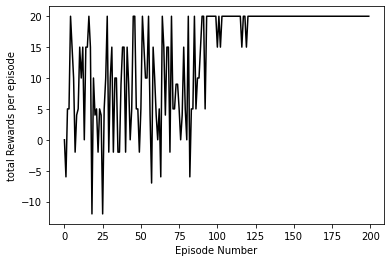

In [ ]:
plt.figure()
plt.plot(myenv_agent.totalRewards,'k')
plt.ylabel('total Rewards per episode')
plt.xlabel('Episode Number')
print('average rewards per episode:', sum(myenv_agent.totalRewards)/200)

**For Part 2, Cartpole and lunar lander are used:**

# **CARTPOLE ENVIRONEMNT**

In [14]:
cartpole_env = gym.make('CartPole-v1')

/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


In [15]:
cartpole_agent = AdvActorCrtici(cartpole_env, Actor, Critic, 123, 510, True, False)

In [16]:
cartpole_agent.train()

0 training...
100 training...
200 training...
300 training...
400 training...
Finished training!!!!!!


Text(0.5, 0, 'Episode')

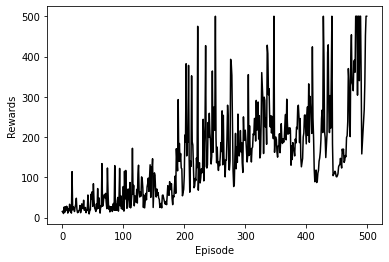

In [ ]:
plt.figure()
plt.plot(cartpole_agent.totalRewards,'k')
plt.ylabel('total Rewards per episode')
plt.xlabel('Episode Number')
print('average rewards per episode:', sum(myenv_agent.totalRewards)/500)

# **LUNAR LANDER**

In [21]:
Lunarlanderv2 = gym.make('LunarLander-v2')

/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


In [22]:
LunarlanderNetwork = AdvActorCrtici(Lunarlanderv2, Actor, Critic, 123, 500, True, False)

/usr/local/lib/python3.7/dist-packages/gym/core.py:257: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  "Function `env.seed(seed)` is marked as deprecated and will be removed in the future. "


In [23]:
LunarlanderNetwork.train()

0 training...


KeyboardInterrupt: ignored

Total rewards per episode graph:

In [ ]:
plt.figure()
plt.plot(LunarlanderNetwork.totalRewards,'k')
plt.ylabel('total Rewards per episode')
plt.xlabel('Episode Number')
print('average rewards per episode:', sum(LunarlanderNetwork.totalRewards)/500)

For evaluation graph:

Text(0.5, 0, 'Episode')

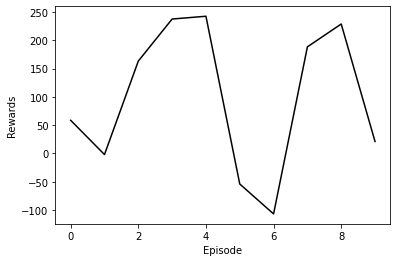

In [ ]:
plt.figure()
plt.plot(LunarlanderNetwork.evaltotalRewards,'k')
plt.ylabel('Rewards')
plt.xlabel('Episode')